
# Example 1: Creating AniSOAP vectors from ellipsoidal frames.
This example demonstrates:

1. How to read ellipsoidal frames from ``.xyz`` file.
2. How to convert ellipsoidal frames to AniSOAP vectors.
3. How to create ellipsoidal frames with ``ase.Atoms``.


In [1]:
from ase.io import read
from ase import Atoms

import numpy as np

from scipy.spatial.transform import Rotation as R
from tqdm.auto import tqdm
from skmatter.preprocessing import StandardFlexibleScaler

from anisoap.representations.ellipsoidal_density_projection import (
    EllipsoidalDensityProjection,
)

import matplotlib.pyplot as plt

/Users/alin62/miniconda3/envs/anisoap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read the first two frames of ellipsoids.xyz, which represent coarse-grained benzene molecules.



In [2]:
frames = read("ellipsoids.xyz", "0:2")
frames_translation = read("ellipsoids.xyz", "0:2")
frames_rotation = read("ellipsoids.xyz", "0:2")

print(f"{len(frames)=}")  # a list of atoms objects
print(f"{frames[0].arrays=}")

len(frames)=2
frames[0].arrays={'numbers': array([0, 0]), 'positions': array([[-0.        , -0.        ,  3.27355258],
       [ 2.86203436,  4.88789961,  6.73143792]]), 'c_q': array([[ 0.15965019,  0.67170996, -0.07507814,  0.71950039],
       [-0.213207  , -0.03290243,  0.26500539,  0.93980442]])}


In this case, the xyz file did not store ellipsoid dimension information.

We will add this information here.



In [3]:
for frame in frames:
    frame.arrays["c_diameter[1]"] = np.ones(len(frame)) * 3.0
    frame.arrays["c_diameter[2]"] = np.ones(len(frame)) * 3.0
    frame.arrays["c_diameter[3]"] = np.ones(len(frame)) * 1.0

print(f"{frames[0].arrays=}")
print(f"{frames[1].arrays=}")

frames[0].arrays={'numbers': array([0, 0]), 'positions': array([[-0.        , -0.        ,  3.27355258],
       [ 2.86203436,  4.88789961,  6.73143792]]), 'c_q': array([[ 0.15965019,  0.67170996, -0.07507814,  0.71950039],
       [-0.213207  , -0.03290243,  0.26500539,  0.93980442]]), 'c_diameter[1]': array([3., 3.]), 'c_diameter[2]': array([3., 3.]), 'c_diameter[3]': array([1., 1.])}
frames[1].arrays={'numbers': array([0]), 'positions': array([[1.05715855, 3.61232694, 6.89484241]]), 'c_q': array([[ 0.79385889,  0.57747976, -0.17079529,  0.08446388]]), 'c_diameter[1]': array([3.]), 'c_diameter[2]': array([3.]), 'c_diameter[3]': array([1.])}


Specify the hypers to create AniSOAP vector.



In [4]:
lmax = 5
nmax = 3

AniSOAP_HYPERS = {
    "max_angular": lmax,
    "max_radial": nmax,
    "radial_basis_name": "gto",
    "rotation_type": "quaternion",
    "rotation_key": "c_q",
    "cutoff_radius": 7.0,
    "radial_gaussian_width": 1.5,
    "basis_rcond": 1e-8,
    "basis_tol": 1e-4,
}
calculator = EllipsoidalDensityProjection(**AniSOAP_HYPERS)

/Users/alin62/miniconda3/envs/anisoap/lib/python3.10/site-packages/anisoap/representations/ellipsoidal_density_projection.py:554: UserWarning: In quaternion mode, quaternions are assumed to be in (w,x,y,z) format.
  warnings.warn(


Create the AniSOAP vector (i.e. the power spectrum).



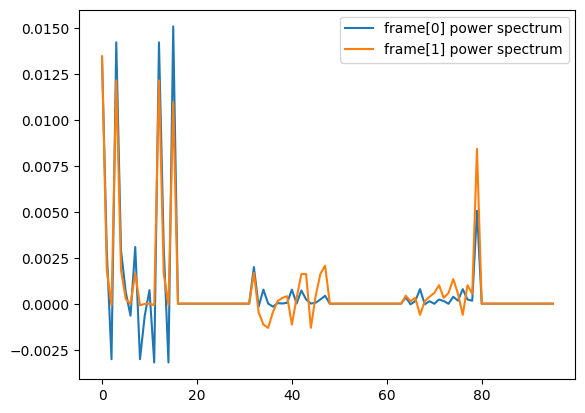

In [5]:
power_spectrum = calculator.power_spectrum(frames)
plt.plot(power_spectrum.T)
plt.legend(["frame[0] power spectrum", "frame[1] power spectrum"])
plt.show()

Here we will demonstrate translation invariance.

A translation vector is used to demonstrate that the power spectrum of ellipsoidal representations is invariant to translation in positions.



In [6]:
print("Old Positions:", frames[0].get_positions(), frames[1].get_positions())
translation_vector = np.array([2.0, 2.0, 2.0])
for frame in frames:
    frame.set_positions(frame.get_positions() + translation_vector)
print("New Positions:", frames[0].get_positions(), frames[1].get_positions())
power_spectrum_translated = calculator.power_spectrum(frames)
if np.allclose(power_spectrum, power_spectrum_translated):
    print("Power spectrum has translational invariance!")
else:
    print("Power spectrum has no translational invariance")

Old Positions: [[-0.         -0.          3.27355258]
 [ 2.86203436  4.88789961  6.73143792]] [[1.05715855 3.61232694 6.89484241]]
New Positions: [[2.         2.         5.27355258]
 [4.86203436 6.88789961 8.73143792]] [[3.05715855 5.61232694 8.89484241]]
Power spectrum has translational invariance!


Here, we demonstrate rotational invariance, rotating all ellipsoids by the same amount.



In [7]:
print("Old Orientations:", frames[0].arrays["c_q"], frames[1].arrays["c_q"])

quaternion = [1, 2, 0, -3]  # random rotation
q_rotation = R.from_quat(quaternion, scalar_first=True)
for frame in frames:
    frame.arrays["c_q"] = R.as_quat(
        q_rotation * R.from_quat(frame.arrays["c_q"], scalar_first=True),
        scalar_first=True,
    )
print("New Orientations:", frames[0].arrays["c_q"], frames[1].arrays["c_q"])

power_spectrum_rotation = calculator.power_spectrum(frames)
if np.allclose(power_spectrum, power_spectrum_rotation, rtol=1e-2, atol=1e-2):
    print("Power spectrum has rotation invariance (with lenient tolerances)")
else:
    print("Power spectrum has no rotation invariance")

Old Orientations: [[ 0.15965019  0.67170996 -0.07507814  0.71950039]
 [-0.213207   -0.03290243  0.26500539  0.93980442]] [[ 0.79385889  0.57747976 -0.17079529  0.08446388]]
New Orientations: [[ 0.26050794  0.20466222 -0.94322073  0.02415869]
 [ 0.71412501  0.08971953 -0.40514029  0.56377054]] [[-0.02878644  0.4417325  -0.55380868 -0.70522314]]
Power spectrum has rotation invariance (with lenient tolerances)


Here's how to create ellipsoidal frames. In this example:

* Each frame contains 2-3 ellipsoids, with periodic boundary conditions.
* The quaternions(``c_q``) and particle dimensions(``c_diameter[i]``) cannot be passed into the Atoms constructor.
* They are attached as data in the Atoms.arrays dictionary.
* I just made up arbitrary postions and orientations. Quaternions should be in (w,x,y,z) format.
* In reality you would choose positions and orientations based on some underlying atomistic model.



In [8]:
frame1 = Atoms(
    symbols="XX",
    positions=np.array([[0.0, 0.0, 0.0], [2.5, 3.0, 2.0]]),
    cell=np.array(
        [
            5.0,
            5.0,
            5.0,
        ]
    ),
    pbc=True,
)
frame1.arrays["c_q"] = np.array([[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0]])
frame1.arrays["c_diameter[1]"] = np.array([3.0, 3.0])
frame1.arrays["c_diameter[2]"] = np.array([3.0, 3.0])
frame1.arrays["c_diameter[3]"] = np.array([1.0, 1.0])

frame2 = Atoms(
    symbols="XXX",
    positions=np.array([[0.0, 1.0, 2.0], [2.0, 3.0, 4.0], [5.0, 5.0, 1.0]]),
    cell=[
        10.0,
        10.0,
        10.0,
    ],
    pbc=True,
)
frame2.arrays["c_q"] = np.array(
    [[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0], [0.0, 0.0, 0.707, 0.707]]
)
frame2.arrays["c_diameter[1]"] = np.array([3.0, 3.0, 3.0])
frame2.arrays["c_diameter[2]"] = np.array([3.0, 3.0, 3.0])
frame2.arrays["c_diameter[3]"] = np.array([1.0, 1.0, 1.0])

frames = [frame1, frame2]

You can then use ``ase.io.write()``/``ase.io.read()`` to save/load these frames for later use.

